# Using the Synth class

This class provide an object that stores a synthetic spectrum, and provides class functions to manipulate them. 

A synth object has the arrays:
* wl
* specI

(We use the same attributes as the Spectrum class on the specpolFlow, to facilitate code replication.)

The class support indexation (e.g. `synth[0:100]`), the use of the `len()` function to return the number of points in the spectrum, etc etc.


In [1]:
import VPtools as vp
import matplotlib.pyplot as plt

path_google = '/Users/vpetit/Library/CloudStorage/GoogleDrive-vpetit@udel.edu/Shared drives/ResearchGroupResources-Files/'

We here open a spectrum from the TLUSTY OSTAR2002 grid, to show the capabilities of the class. For more information about the TLUSTY grid itself, see the associated tutorial (LINK)


In [2]:
path = "ReferenceMaterial/TLUSTY/OSTAR2002/Gvispec"
spec = vp.tlusty.read_norm(path_google+path+'/G27500g300v10.vis')

Text(0.5, 0, 'Wavelength (AA)')

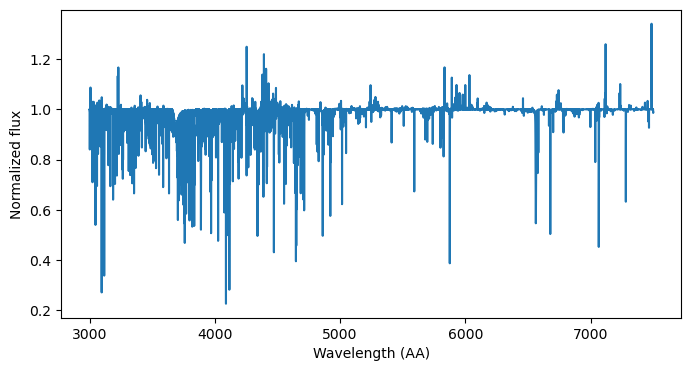

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(spec.wl, spec.specI)

ax.set_ylabel('Normalized flux')
ax.set_xlabel('Wavelength (AA)')

A few notes:
* The wavelength axis is not forced to be uniform (neither in wavelength of velocity) -- the characteristics of the wavelegnth axis will depend on the model. Therefore do not assume that the interval between data points in the synthetic spectrum is constant (this is important for e.g. convolution). 
* The wavelength unit is also not forced or coverted. 
* The flux does not have to be normalized (for example the TLUSTY OBSTAR grids provides continnum fluxes as well)

## Adding rotation

Some synthetic spectra will have been calculated with rotation already (this is usually a better calculation). But it is possible to approximate a rotating star from a non-rotating model by performing a convolution with a rotational kernel (ADD REF HERE). 

A few caveats:
* The methods below includes the impact of continuum limb-darkening (see PHYS 633 notes). This is controled by a factor called $\epsilon$. 
* The methods below do not include the impact of the 'line limb-darkening' -- this is because the formation of the spectral line itself changes when the slope of the source function changes with the incidence angle (in a flat atmosphere, that would be the $\mu$ angle). This can be understand this way: 

    1. A linear limb-darkening law is the same as having a constant slope for the source function as a function of vertical optical depth.
    2. A spectral line can only be formed if there is a gradient of source function (i.e. temperature).
    3. Using the flat atmophere here as an example, the ray at the very limb ($\mu=0) does not have a gradient of source function anymore, and thus there should not be a spectral line formed. 
    4. But in the convolution method, we assume that the line is the same everywhere, and we only take into account the change in continnum on the limb (and not the fact that the line will be weaker with respect to the continuum)
    5. ADD A REFERENCE TO THE NOTES IN PYRAVEN THAT SHOWS THIS WITH THE MATH?

    This means that there might be some slight differences when compared with codes that performs direct disk integration that includes rotation (e.g. Synth3 computes intensity spectra for a set of $\mu$ angles, and are used to compute a disk integration with rotation). 
* The two methods below will work with wavelength grids that are not uniform. 
    - This said, the wavelength grid needs to have a high resolution (especially for low vsini). If the grid is not high-resolution, then interpolating on a finer grid might be better. 
    - These methods will be relatively slow. Once could interpolate the spectrum on a fine grid in velocity space, and use a FFT convolution instead. 
    - Students: if you need something quicker than this method, come talk to me. 

* Some models includes the impact of the stellar wind, and have spectral lines that are formed in the wind (usually in emission). The rotation covolution only applies to the spectrum that originates from the star's photosphere. Therefore when using models like CMFGEN and poWR, you should be wary of the result of the convolution for not only the wind lines themselves, but also the photospheric lines that are close to wind lines. 

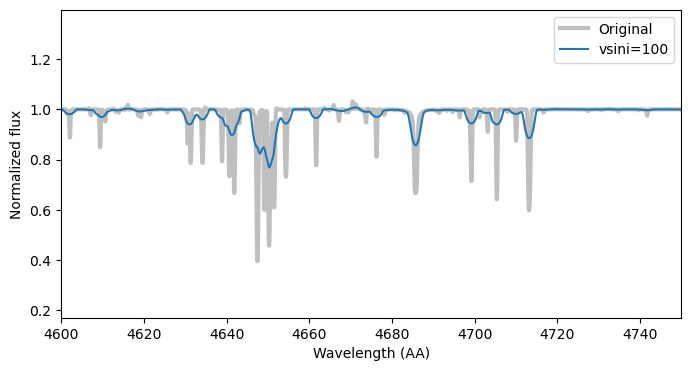

In [4]:
vsini = 100.0 # projected rotational velocity
eps = 0.5 # limb darkening coefficient
rot = spec.convolveRot(vsini, eps)


fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(spec.wl, spec.specI, c='0.75', lw=3, label='Original')
ax.plot(rot.wl, rot.specI, label='vsini=100')
ax.set_ylabel('Normalized flux')
ax.set_xlabel('Wavelength (AA)')
ax.set_xlim(4600, 4750)
ax.legend(loc=0)

## Degrading the resolution

To match the spectral resolution, we first need to convolve our synthetic spectrum with the spectral point spread function. 

To do this, we can use the function that is already built into the specpolFlow package, by transforming our Synth object into a Spectrum object. A Spectrum object has more columns (error bar, Stokes parameters, etc), so these are set to zero

The example below show a quite low resolution (like FORS). For an instrument like ESPaDONs, R=65,000, and it will not make a lot of difference. 

In [ ]:
R = 1000 # lambda / Delta lambda or c/v -- this is the ~ resolution for FORS1
res1 = rot.to_spf().convolveR(R)

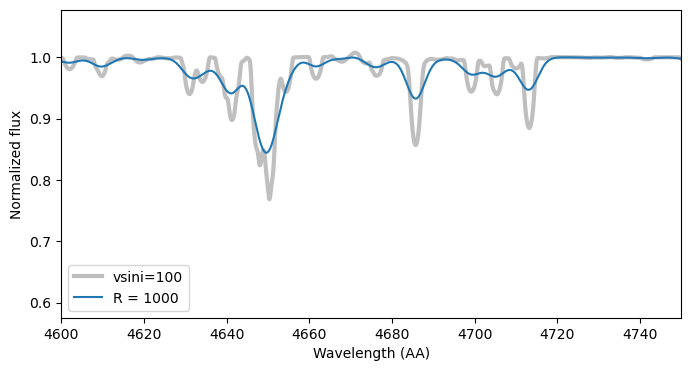

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(rot.wl, rot.specI, c='0.75', lw=3, label='vsini=100')
ax.plot(res1.wl, res1.specI, label='R = 1000')
ax.set_ylabel('Normalized flux')
ax.set_xlabel('Wavelength (AA)')
ax.set_xlim(4600, 4750)
ax.legend(loc=0)

# Interpolating to the same wavelength grid as an observation

For visual comparison, this is not necessary because degrading the resolution like above is sufficient, unless the spectral point spread function of the spectrograph is not well sampled by the size of the pixels on the CCD. 

But if this is not the case (the spectrum is *undersampled*) or if you need to e.g. compute a $\chi^2$ between the model and the observation, then we need to interpolate the model on the same wavelength grid as the data. 

[] TODO: load an observation
[] Interpolating with spectral orders (i.e. espadons spectrum)